# Personalized Medicine Kaggle Competition
> "This was my approach to the Personalized Healthcare Redefining Cancer Treatment Kaggle competition. The goal of the competition was to create a machine learning algorithm that can classify genetic variations that are present in cancer cells."

- toc:true
- branch: master
- badges: true
- comments: false
- author: Dario Arcos-Díaz
- categories: [machine_learning, classification, healthcare]
- image: images/Kaggle_logo.png

This notebook describes my approach to the [Kaggle competition](https://www.kaggle.com/c/msk-redefining-cancer-treatment) named in the title. This was a research competition at Kaggle in cooperation with the Memorial Sloan Kettering Cancer Center (MSKCC).

The goal of the competition was to create a machine learning algorithm that can classify genetic variations that are present in cancer cells.

Tumors contain cells with many different abnormal mutations in their DNA: some of these mutations are the drivers of tumor growth, whereas others are neutral and considered *passengers*. Normally, mutations are manually classified into different categories after literature review by clinicians. The dataset made available for this competition contains mutations that have been manually anotated into 9 different categories. The goal is to predict the correct category of mutations in the test set.

The model and submission described here got me to the 140th place (out of 1386 teams) or top 11%.

## Data

The data comes in two different kinds of files: one of them contains information about the genetic variants (*training_variants* and *stage2_test_variants.csv*) and the other contains the text (clinical evidence) that was used to manually classify the variants (*training_text* and *stage2_test_text.csv*). The training data contains a class target feature corresponding to one of the 9 categories that variants can be classified as.

*Note: the "stage2" prefix of the test files is due to the nature of the competition. There was an initial test set that was used at the beginning of the competition and a "stage2" test set that was used in the final week before the deadline to make the submissions.*

In [1]:
import os
import re
import string
import pandas as pd
import numpy as np

In [2]:
train_variant = pd.read_csv("input/training_variants")
test_variant = pd.read_csv("input/stage2_test_variants.csv")
train_text = pd.read_csv("input/training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text = pd.read_csv("input/stage2_test_text.csv", header=None, skiprows=1, names=["ID", "Text"])
train = pd.merge(train_variant, train_text, how='left', on='ID')
train_y = train['Class'].values
train_x = train.drop('Class', axis=1)
train_size=len(train_x)
print('Number of training variants: %d' % (train_size))
# number of train data : 3321

test_x = pd.merge(test_variant, test_text, how='left', on='ID')
test_size=len(test_x)
print('Number of test variants: %d' % (test_size))
# number of test data : 5668

test_index = test_x['ID'].values
all_data = np.concatenate((train_x, test_x), axis=0)
all_data = pd.DataFrame(all_data)
all_data.columns = ["ID", "Gene", "Variation", "Text"]

Number of training variants: 3321
Number of test variants: 986


In [3]:
all_data.head()

,ID,Gene,Variation,Text
0,0,FAM58A,Truncating Mutations,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,Oncogenic mutations in the monomeric Casitas B...


The data from the different train and test files is now consolidated into one single file. This is necessary for the correct vectorization of the text data and categorical data later on. We can see that the text information resembles scientific article text. We will process this consolidated file in the next step.

##  Preprocessing

In order to be able to use this data to train a machine learning model, we need to extract the features from the dataset. This means that we have to transform the text data into vectors that can be understood by an algorithm. As I am not an expert in Natural Language Processing, I applied a modified version of [this script published on Kaggle.](https://www.kaggle.com/alyosama/doc2vec-with-keras-0-77) Afterwards we will have the data in a form that I can use to train a neural network.

In [4]:
# Pre-processing script by Aly Osama https://www.kaggle.com/alyosama/doc2vec-with-keras-0-77

from nltk.corpus import stopwords
from gensim.models.doc2vec import LabeledSentence
from gensim import utils

def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", str(text))
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]    
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
    text= text.translate(str.maketrans("","", string.punctuation))
    return text

allText = all_data['Text'].apply(cleanup)
sentences = constructLabeledSentences(allText)
allText.head()

Using TensorFlow backend.


0    cyclindependent kinases cdks regulate variety ...
1    abstract background nonsmall cell lung cancer ...
2    abstract background nonsmall cell lung cancer ...
3    recent evidence demonstrated acquired uniparen...
4    oncogenic mutations monomeric casitas blineage...
Name: Text, dtype: object

In [ ]:
# Pre-processing script by Aly Osama https://www.kaggle.com/alyosama/doc2vec-with-keras-0-77

# PROCESS TEXT DATA
from gensim.models import Doc2Vec

Text_INPUT_DIM=300

text_model=None
filename='docEmbeddings_5_clean.d2v'
if os.path.isfile(filename):
    text_model = Doc2Vec.load(filename)
else:
    text_model = Doc2Vec(min_count=1, window=5, size=Text_INPUT_DIM, sample=1e-4, negative=5, workers=4, iter=5,seed=1)
    text_model.build_vocab(sentences)
    text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.iter)
    text_model.save(filename)

text_train_arrays = np.zeros((train_size, Text_INPUT_DIM))
text_test_arrays = np.zeros((test_size, Text_INPUT_DIM))

for i in range(train_size):
    text_train_arrays[i] = text_model.docvecs['Text_'+str(i)]

j=0
for i in range(train_size,train_size+test_size):
    text_test_arrays[j] = text_model.docvecs['Text_'+str(i)]
    j=j+1
    
print(text_train_arrays[0][:10])

# PROCESS GENE DATA
from sklearn.decomposition import TruncatedSVD
Gene_INPUT_DIM=25

svd = TruncatedSVD(n_components=25, n_iter=Gene_INPUT_DIM, random_state=12)

one_hot_gene = pd.get_dummies(all_data['Gene'])
truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)

one_hot_variation = pd.get_dummies(all_data['Variation'])
truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)

# ENCODE THE LABELS FROM INTEGERS TO VECTORS
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_y)
encoded_y = np_utils.to_categorical((label_encoder.transform(train_y)))
print(encoded_y[0])

We have processed the train labels, as printed above (`encoded_y`), into vectors that contain 1 in the index of the category that the sample belongs to, and zeros in all other indexes.

Moreover, the training and test sets are now stacked together to look like this:

In [ ]:
train_set=np.hstack((truncated_one_hot_gene[:train_size],truncated_one_hot_variation[:train_size],text_train_arrays))
test_set=np.hstack((truncated_one_hot_gene[train_size:],truncated_one_hot_variation[train_size:],text_test_arrays))

print('Training set shape is: ', train_set.shape)  # (3321, 350)
print('Test set shape is: ', test_set.shape)  # (986, 350)

print('Training set example rows:')
print(train_set[0][:10])
# [ -2.46065582e-23  -5.21548048e-19  -1.95048372e-20  -2.44542833e-22
#  -1.19176742e-22   1.61985461e-25   2.93618862e-25  -6.23860891e-27
#   1.14583929e-28  -1.79996588e-29]

print('Test set example rows:')
print(test_set[0][:10])
# [  9.74220189e-33  -1.31484613e-27   4.37925347e-27  -9.88109317e-29
#    7.66365772e-27   6.58254980e-26  -3.74901712e-26  -8.97613299e-26
#   -3.75471102e-23  -1.05563623e-21]

Our data is now ready to be fed into a machine learning model, in this case, into a neural network in TensorFlow.

## Training a 4-layer neural network for classification

The next step is to create a neural network on TensorFlow. I am using a fully-connected neural network with 4 layers. For details on how the network is built, you can check my [TensorFlow MNIST notebook](https://github.com/dariodata/TensorFlow-MNIST/blob/master/TensorFlow-MNIST.ipynb). Wherever necessary, I will explains what adaptations were specifically necessary for this challenge.

In [ ]:
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

I found it useful to add the current timestamp to the name of the files that the code will output. This helped me to uniquely identify the results from each run.

In [13]:
timestr = time.strftime("%Y%m%d-%H%M%S")
dirname = 'output/'  # output directory
filename = ''

I select 20% of the training data to use as a validation set and be able to quantify my variance (watch out for overfitting), as I don't want to have an algorithm that only works well with this specific training data set that was provided, but one that generalizes as well as possible.

In [14]:
# split data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(train_set, encoded_y, test_size=0.20, random_state=42)
X_train, X_val, Y_train, Y_val = X_train.T, X_val.T, Y_train.T, Y_val.T

# transpose test set
X_test = test_set.T

In [15]:
# view data set shapes
print('X_train: ', X_train.shape)
print('X_val: ', X_val.shape)
print('Y_train: ', Y_train.shape)
print('Y_val: ', Y_val.shape)
print('X_test: ', X_test.shape)

X_train:  (350, 2656)
X_val:  (350, 665)
Y_train:  (9, 2656)
Y_val:  (9, 665)
X_test:  (350, 986)


Now I define the functions needed to build the neural network.

In [16]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.

    Arguments:
    n_x -- scalar, dimensions of the input
    n_y -- scalar, number of classes (from 0 to 8, so -> 9)

    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    """

    X = tf.placeholder(tf.float32, shape=(n_x, None), name='X')
    Y = tf.placeholder(tf.float32, shape=(n_y, None), name='Y')

    return X, Y

In [17]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow.

    Returns:
    parameters -- a dictionary of tensors containing W and b for every layer
    """

    tf.set_random_seed(1)

    W1 = tf.get_variable('W1', [350, X_train.shape[0]], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable('b1', [350, 1], initializer=tf.zeros_initializer())
    W2 = tf.get_variable('W2', [350, 350], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable('b2', [350, 1], initializer=tf.zeros_initializer())
    W3 = tf.get_variable('W3', [100, 350], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable('b3', [100, 1], initializer=tf.zeros_initializer())
    W4 = tf.get_variable('W4', [9, 100], initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b4 = tf.get_variable('b4', [9, 1], initializer=tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4}

    return parameters

In [18]:
def forward_propagation(X, parameters, keep_prob1, keep_prob2):
    """
    Implements the forward propagation for the model: (LINEAR -> RELU)^3 -> LINEAR -> SOFTMAX

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W" and "b" for every layer
                  the shapes are given in initialize_parameters

    Returns:
    Z4 -- the output of the last LINEAR unit (logits)
    """

    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']

    Z1 = tf.matmul(W1, X) + b1  # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)  # A1 = relu(Z1)
    A1 = tf.nn.dropout(A1, keep_prob1)  # add dropout
    Z2 = tf.matmul(W2, A1) + b2  # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)  # A2 = relu(Z2)
    A2 = tf.nn.dropout(A2, keep_prob2)  # add dropout
    Z3 = tf.matmul(W3, A2) + b3  # Z3 = np.dot(W3,Z2) + b3
    A3 = tf.nn.relu(Z3)
    Z4 = tf.matmul(W4, A3) + b4

    return Z4

In [19]:
def compute_cost(Z4, Y):
    """
    Computes the cost

    Arguments:
    Z4 -- output of forward propagation (output of the last LINEAR unit), of shape (n_classes, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z4

    Returns:
    cost - Tensor of the cost function
    """

    # transpose to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z4)
    labels = tf.transpose(Y)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))

    return cost

In [20]:
def random_mini_batches(X, Y, mini_batch_size, seed=0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector, of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    m = X.shape[1]  # number of training examples
    mini_batches = []
    np.random.seed(seed)

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0], m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(
        m / mini_batch_size)  # number of mini batches of size mini_batch_size in your partitioning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size: k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size: k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size: m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size: m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [21]:
def predict(X, parameters):
    W1 = tf.convert_to_tensor(parameters['W1'])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    W4 = tf.convert_to_tensor(parameters["W4"])
    b4 = tf.convert_to_tensor(parameters["b4"])

    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3,
              "W4": W4,
              "b4": b4}

    x = tf.placeholder("float", [X_train.shape[0], None])
    keep_prob1 = tf.placeholder(tf.float32, name='keep_prob1')
    keep_prob2 = tf.placeholder(tf.float32, name='keep_prob2')

    z4 = forward_propagation(x, params, keep_prob1, keep_prob2)
    p = tf.nn.softmax(z4, dim=0)  # dim=0 because the classes are on that axis
    # p = tf.argmax(z4) # this gives only the predicted class as output

    sess = tf.Session()
    prediction = sess.run(p, feed_dict={x: X, keep_prob1: 1.0, keep_prob2: 1.0})

    return prediction

And now I define the model function which is in fact the neural network that we will train afterwards. An important difference with respect to [my previous MNIST example](https://github.com/dariodata/TensorFlow-MNIST/blob/master/TensorFlow-MNIST.ipynb) is that I added an additional regularization term to the cost function. I used L2 regularization to penalize the weights in all four layers. The bias was not penalized as this is not necessary. The strictness of this penalty was given by a `beta` constant defined at 0.01.

Why use additional regularization? Because this allowed me to decrease the variance, i.e. decrease the difference in performance of the model with the training set compared to the validation set. This produced my best submission in the competition.

In [22]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001,
          num_epochs=1000, minibatch_size=64, print_cost=True):
    """
    Implements a four-layer tensorflow neural network: (LINEAR->RELU)^3->LINEAR->SOFTMAX.

    Arguments:
    X_train -- training set, of shape (input size, number of training examples)
    Y_train -- test set, of shape (output size, number of training examples)
    X_test -- training set, of shape (input size, number of training examples)
    Y_test -- test set, of shape (output size, number of test examples)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    ops.reset_default_graph()  # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)  # to keep consistent results
    seed = 3  # to keep consistent results
    (n_x, m) = X_train.shape  # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]  # n_y : output size
    costs = []  # To keep track of the cost
    t0 = time.time()  # to mark the start of the training

    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    keep_prob1 = tf.placeholder(tf.float32, name='keep_prob1')  # probability to keep a unit during dropout
    keep_prob2 = tf.placeholder(tf.float32, name='keep_prob2')

    # Initialize parameters
    parameters = initialize_parameters()

    # Forward propagation
    Z4 = forward_propagation(X, parameters, keep_prob1, keep_prob2)

    # Cost function
    cost = compute_cost(Z4, Y)
    regularizers = tf.nn.l2_loss(parameters['W1']) + tf.nn.l2_loss(parameters['W2']) + tf.nn.l2_loss(parameters['W3']) \
                   + tf.nn.l2_loss(parameters['W4'])  # add regularization term
    beta = 0.01  # regularization constant
    cost = tf.reduce_mean(cost + beta * regularizers)  # cost with regularization

    # Backpropagation: Define the tensorflow AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:

        # Run the initialization
        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.  # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size)  # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch

                # Run the session to execute the "optimizer" and the "cost"
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y,
                                                                           keep_prob1: 0.7, keep_prob2: 0.5})
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print("Cost after epoch {}: {:f}".format(epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z4), tf.argmax(Y))
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        train_cost = cost.eval({X: X_train, Y: Y_train, keep_prob1: 1.0, keep_prob2: 1.0})
        test_cost = cost.eval({X: X_test, Y: Y_test, keep_prob1: 1.0, keep_prob2: 1.0})
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train, keep_prob1: 1.0, keep_prob2: 1.0})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test, keep_prob1: 1.0, keep_prob2: 1.0})

        print('Finished training in %s s' % (time.time() - t0))
        print("Train Cost:", train_cost)
        print("Test Cost:", test_cost)
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per fives)')
        plt.title("Learning rate = {}, beta = {},\n"
                  "test cost = {:.6f}, test accuracy = {:.6f}".format(learning_rate, beta, test_cost, test_accuracy))
        global filename
        filename = timestr + '_NN4Lstage2_lr_{}_beta_{}_cost_{:.2f}-{:.2f}_acc_{:.2f}-{:.2f}'.format(
            learning_rate, beta, train_cost, test_cost, train_accuracy, test_accuracy)
        plt.savefig(dirname + filename + '.png')

        return parameters

Note that the model function will return the learned parameters from the network and additionally will plot the cost after each epoch. The plot is also saved as a file that includes the timestamp as well as the learning rate, beta, cost and accuracy information for this particular run.

Now it's time to train the model using the train and validation data:

Cost after epoch 0: 6.607861


Cost after epoch 100: 1.389869


Cost after epoch 200: 0.988806


Cost after epoch 300: 0.882713


Cost after epoch 400: 0.833693


Cost after epoch 500: 0.811457


Cost after epoch 600: 0.793379


Cost after epoch 700: 0.773927


Cost after epoch 800: 0.762247


Cost after epoch 900: 0.767449


Parameters have been trained!


Finished training in 498.4203100204468 s
Train Cost: 0.665462
Test Cost: 1.74987
Train Accuracy: 0.979292
Test Accuracy: 0.643609


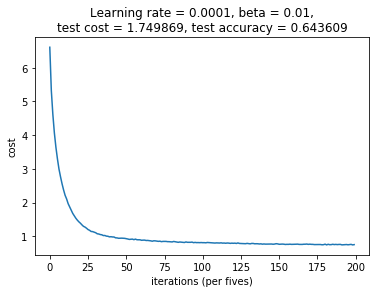

In [24]:
# train the model and get learned parameters
parameters = model(X_train, Y_train, X_val, Y_val)

From my validation results we can observe that the network learned nicely. However, the final cost of the training data was 0.665462, where as the validation data had a final cost of 1.74987. This is a large difference and an indication that the model is overfitting. Moreover the accuracy (defined here as the fraction of correct predictions) is very high (97.9%) for the training data and only 64.3% for the validation set. Another indication that the model is overfitting even though I have used both dropout and L2 regularization to counteract this.

## Make predictions

We use the learned parameteres to make a prediction on the test data.

In [25]:
# use learned parameters to make prediction on test data
prediction = predict(X_test, parameters)

Let's look at an example of a prediction. As we can see below, the prediction consists of the probabilities of the entry belongin to each of the nine different categories (this was the format needed for this competition).

In [29]:
prediction[:,0]

array([ 0.36503336,  0.21219006,  0.01297534,  0.14676626,  0.08375936,
        0.09217557,  0.02737238,  0.03150512,  0.02822249], dtype=float32)

In [30]:
prediction.shape

(9, 986)

All we have to do now is create a submission .csv file to save our prediction results.

In [26]:
# create submission file
submission = pd.DataFrame(prediction.T)
submission['id'] = test_index
submission.columns = ['class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9', 'id']
submission.to_csv(dirname + filename + '.csv', index=False)

## Results interpretation

Using this neural network model, my submission to Kaggle yielded following results:

- Public score (based on a portion of the test data by Kaggle to provide an indication of performance during the competition): Loss = 1.69148
- Private score (based on a different portion of the test data by Kaggle to provide the final score at the end of the competition): Loss = 2.74500

The discrepancy between these two scores further shows that overfitting is an issue in working with this data in a neural network model. My model could benefit from increasing the training data and a higher regularization.